In [197]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.font_manager import FontProperties

import cv2
import os
import pickle
import random

from sklearn.model_selection import train_test_split
from sklearn.utils.multiclass import unique_labels
from sklearn.metrics import confusion_matrix, classification_report
from sklearn import svm

from skimage.feature import hog
from skimage import exposure

from pathlib import Path

from keras.preprocessing import image
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense

# Preprocessing Data

In [ ]:
def collecting_image(dirs):
    """
        dirs - directories in a certain path folder.
        Takes png files in each directory and returns to a rgb matrix.
        If a png file is none, remove the png file.
        os.remove() will clean all broken png files.
    """
    image_data = []
    labels = []
    for folder in sorted(dirs):
        label = str(folder).split('/')[-1]
        count = 0
        count1 = 0 
        # Taking all png files in img_path (a pokemon folder)
        for img_path in folder.glob("*.png"):
            img_path = str(img_path)
            img = cv2.imread(img_path) 
            if img is not None:
                img = cv2.resize(img,(64,64)) # Resize an image to 64 pixels by 64 pixels
                img_array = image.img_to_array(img) # Convert an image to an array
                image_data.append(img_array)
                labels.append(label)
                count += 1
            else:
                print(img_path)
                os.remove(img_path)
                print("File Removed")
                count1 += 1
    print('# of Images: {} for {}'.format(count, label)) 
    print("# of Removed Images", count1)
    
    return(image_data, labels)


In [ ]:
# p = Path("./data/pokemon/")
# dirs = p.glob("*")
# image_data, labels = collecting_image(dirs)

# Saving Pokemon Label Dictionary to pickle


In [ ]:
# labels_dict = {key: val for key, val in enumerate(sorted(set(labels)), 0)}
# pickle.dump(labels_dict, open("data/pokemon_label.p", 'wb'))
# pickle.dump(image_data, open("data/image_data.p", 'wb'))
# pickle.dump(labels, open("data/labels.p", 'wb'))

## Loading Pickles

In [2]:
labels_dict = pickle.load(open("data/pokemon_label.p", 'rb'))
image_data = pickle.load(open('data/image_data.p','rb'))
labels = pickle.load(open('data/labels.p','rb'))

In [84]:
X = np.array(image_data)
y = np.array(labels)
print(X.shape)
print(y.shape)

(42022, 64, 64, 3)
(42022,)


In [11]:
def drawImg(img,label):
    """ 
        Draw an input image with a label
    """
    plt.title(label)
    plt.axis('off')
    plt.imshow(img)
    plt.show()

In [5]:
def pokemon_to_keys(y,labels_dict):
    """ y - list of pokemons
        labels_dict - {(0,151):'pokemon'}
        returns to corresponding key.
        
    """
    new_y = []
    for y_element in y:
        for k, v in labels_dict.items():
            if y_element == v:
                new_y.append(k)
    return(np.array(new_y))

## Normalizing Data

In [86]:
# 'float32' type data is more efficiently trained in a neural network. Also can be normalized.
X = X.astype('float32') / 255.0
# Converting Pokemon labels to corresponding keys
y = pokemon_to_keys(y, labels_dict)

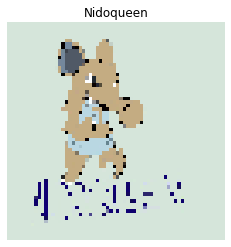

In [27]:
some_number = random.randint(a=0, b=len(X))

drawImg(X[some_number],y[some_number])


In [ ]:
print(X_train.shape)
print(X_test.shape)
assert (X_train.shape[0] + X_test.shape[0] == X.shape[0])

# EDA

In [29]:
from collections import Counter

pokemons, counts = zip(*Counter(y).items())
df_images = pd.DataFrame(index=pokemons, data={'# of Images':counts}) # Data Frame of the data
df_images.head() 

,# of Images
Abra,204
Aerodactyl,764
Alakazam,722
Arbok,607
Arcanine,590


In [30]:
avg_num_images = df_images['# of Images'].mean()
median_num_images = df_images['# of Images'].median()

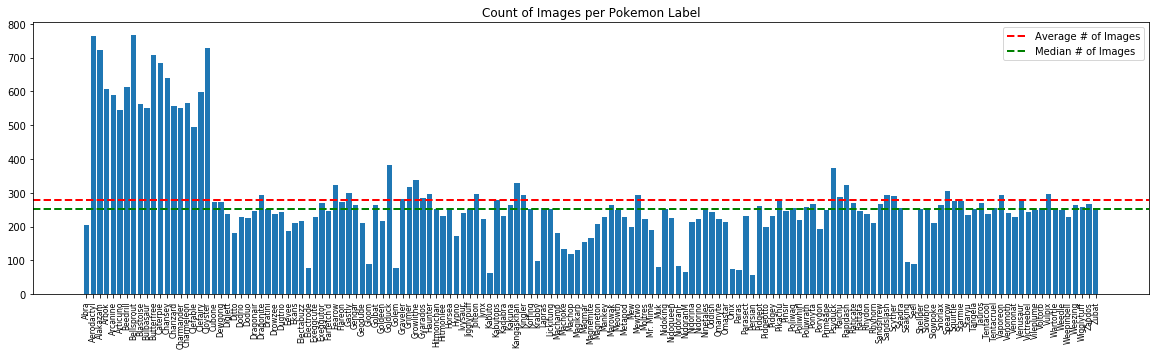

In [31]:
plt.figure(figsize=(20,5))
plt.bar(range(len(df_images)), df_images['# of Images'].values)
plt.axhline(avg_num_images, color='r', linestyle='dashed', linewidth=2, label='Average # of Images')
plt.axhline(median_num_images, color='g', linestyle='dashed', linewidth=2, label='Median # of Images')

plt.xticks(range(len(df_images)), df_images.index.values, size=7.5,rotation='vertical')
plt.legend()
plt.title('Count of Images per Pokemon Label')

plt.show()

In [70]:
def get_last_10(df_images,n):
    """ Returns to a Dataframe, which represents 'n' lowest number of images
    """
    return (df_images.sort_values(by=['# of Images'])[0:n])

Text(0, 0.5, 'Number of Images')

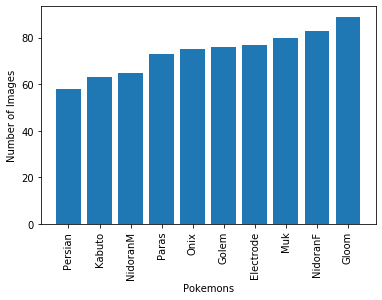

In [79]:
plt.bar(x=range(10), height=get_last_10(df_images,10)['# of Images'].values)
plt.xticks(range(10), get_last_10(df_images,10).index.values, rotation=90)
plt.xlabel('Pokemons')
plt.ylabel('Number of Images')


## Generate Some Random Pokemons

In [80]:
def random_pokemon_key(key, array):
    return int(random.choice(np.argwhere(array == key)))

In [81]:
def display_sample_pokemons(samples_indices, img_array, labels, pred_labels=None, pred_probs=None):
    n = 0
    nrows = 4
    ncols = 5
    fig, ax = plt.subplots(nrows,ncols,sharex=True,sharey=True,figsize=(12,10))
    plt.subplots_adjust(wspace=0, hspace=0)
    for row in range(nrows):
        for col in range(ncols):
            index = samples_indices[n]

            ax[row,col].imshow(img_array[index])
            ax[row,col].axis('off')
            
            actual_label = labels_dict[labels[index]]
            actual_text = "Actual : {}".format(actual_label)
            
            ax[row,col].add_patch(patches.Rectangle((0, 53),64,25,color='white'))
            font0 = FontProperties()
            font = font0.copy()
            font.set_family("sans-serif")
            ax[row,col].text(1,54, actual_text , horizontalalignment='left', fontproperties=font,
                    verticalalignment='top',fontsize=8, color='black',fontweight='bold')
            if (pred_labels!= None and pred != None):
                pred_label = labels_dict[pred_labels[index]]
                pred_prob = max(pred_probs[index])*100
                pred_text = "{} : {:.0f}%".format(pred_label,pred_prob)
                ax[row,col].text(1, 59, pred_text , horizontalalignment='left', fontproperties=font,
                                 verticalalignment='top',fontsize=8, color='black',fontweight='bold')
            n += 1
            

In [93]:
rand_pokemon_keys = random.sample(range(0,151),20)
samples_indices = [random_pokemon_key(key, y) for key in rand_pokemon_keys]
#display_sample_pokemons(samples_indices, X, y)

# Feature Extraction
## Histogram of Oriented Gradients


<font size="4">Histogram of Oriented gradients calculates a gradient magnitude between horizontal gradient and vertical gradient of corresponding pixel's intensity value and a angle between them by arctan(grad_y/ grad_x) in each window of an image. Therefore, HOG detects edges in an image.
Check more about HOG here https://www.learnopencv.com/histogram-of-oriented-gradients/ </font>


In [95]:
def display_hog_sample_pokemons(samples_indices, img_array, labels):
    n = 0
    nrows = 4
    ncols = 5
    assert (len(samples_indices) == nrows * ncols)
    fig, ax = plt.subplots(nrows,ncols,sharex=True,sharey=True,figsize=(12,10))
    plt.subplots_adjust(wspace=0, hspace=0)
    for row in range(nrows):
        for col in range(ncols):
            index = samples_indices[n]
            gray = cv2.cvtColor(img_array[index], cv2.COLOR_BGR2GRAY)
            # Compute the gradient vector or edge orientations at each pixel
            fd, hog_img = hog(gray, orientations=9, pixels_per_cell=(2, 2),
                    cells_per_block=(2, 2), visualize=True, block_norm='L1')
            
            # Rescale histogram for better display
            hog_image_rescaled = exposure.rescale_intensity(hog_img, in_range=(0,10))
            
            ax[row,col].imshow(hog_image_rescaled)
            ax[row,col].axis('off')
            
            actual_label = labels_dict[labels[index]]
            actual_text = "Actual : {}".format(actual_label)
            
            ax[row,col].add_patch(patches.Rectangle((0, 53),64,25,color='white'))
            font0 = FontProperties()
            font = font0.copy()
            font.set_family("sans-serif")
            ax[row,col].text(1,59, actual_text , horizontalalignment='left', fontproperties=font,
                    verticalalignment='top',fontsize=8, color='black',fontweight='bold')
            n += 1
            

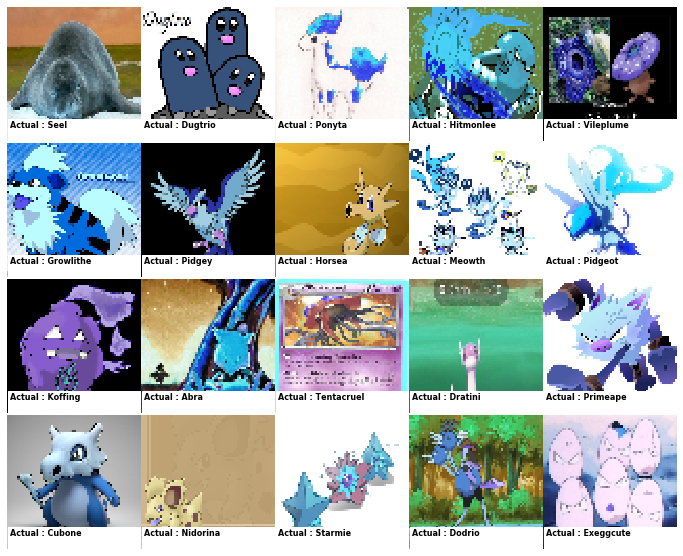

In [91]:
display_sample_pokemons(samples_indices, X, y)

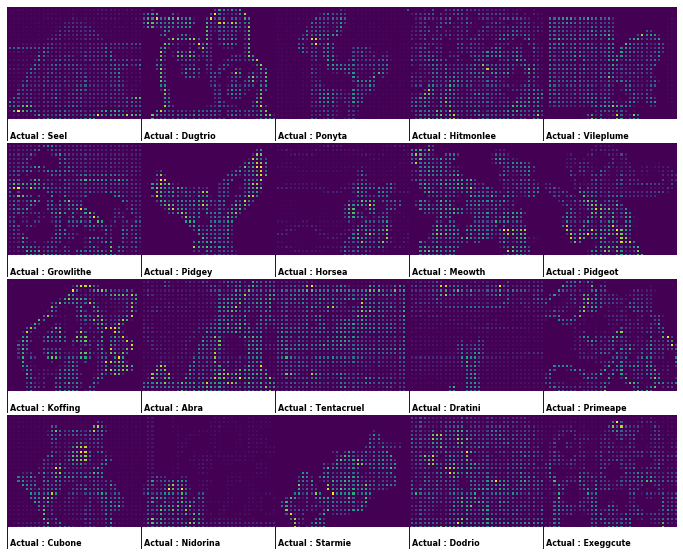

In [96]:
display_hog_sample_pokemons(samples_indices, X, y)

## Examples of Pokemons

In [ ]:
squirtle_keys = np.empty(20)
squirtle_keys.fill(129)
squirtle = [random_pokemon_key(key, y) for key in squirtle_keys]

In [ ]:
pikachu_keys = np.empty(20)
pikachu_keys.fill(103)
pikachu = [random_pokemon_key(key, y) for key in pikachu_keys]

In [ ]:
display_sample_pokemons(pikachu, X, y)

In [ ]:
display_hog_sample_pokemons(pikachu, X, y)

In [ ]:
display_sample_pokemons(squirtle, X, y)

In [ ]:
display_hog_sample_pokemons(squirtle, X, y)

# Support Vector Classifier

In [131]:
# The normalization performed by scikit-image is not the one recommended by the paper. 
def extract_hog(img_array):
    """
        Extract Histogram of Oriented Gradients feature descriptions for an image.
        
    """
    winSize = (64,64)
    blockSize = (4,4)
    blockStride = (4,4)
    cellSize = (2,2)
    nbins = 9
    derivAperture = 1
    winSigma = -1
    histogramNormType = 0
    L2HysThreshold = 0.2
    gammaCorrection = 1
    nlevels = 64
    signedGradient = True
    
    hogD = cv2.HOGDescriptor(winSize,
                            blockSize,
                            blockStride,
                            cellSize,
                            nbins,
                            derivAperture,
                            winSigma,
                            histogramNormType,
                            L2HysThreshold,
                            gammaCorrection,
                            nlevels,
                            signedGradient
                            )
    list_fd = []
    for image in img_array:
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        fd = hogD.compute(image.astype(np.uint8))
        fd = fd.T   # Convert to Transpose 
        list_fd.append(fd)
    list_fd = np.squeeze(list_fd) # Remove single-dimensional entries
    return list_fd

In [132]:
hog_fd = extract_hog(X)
hog_fd.shape # 64 x (4 x 4) x 9

In [138]:
hog_X_train, hog_X_test, hog_y_train, hog_y_test = train_test_split(hog_fd, y, test_size=0.20)

In [143]:
pickle.dump(hog_X_train, open("data/hog_X_train.p", 'wb'))
pickle.dump(hog_X_test, open("data/hog_X_test.p", 'wb'))
pickle.dump(hog_y_train, open("data/hog_y_train", 'wb'))
pickle.dump(hog_y_test, open("data/hog_y_test.p",'wb'))

### Loading hog train and test data

In [120]:
hog_X_train = pickle.load(open("data/hog_X_train.p", 'rb'))
hog_X_test = pickle.load(open("data/hog_X_test.p", 'rb'))
hog_y_train = pickle.load(open("data/hog_y_train", 'rb'))
hog_y_test = pickle.load(open("data/hog_y_test.p",'rb'))

## Building Support Vector Classifier using OpenCV library

In [124]:
cv2_svc = cv2.ml.SVM_create()
cv2_svc.setC(2.67) # Setting Soft SVC
cv2_svc.setGamma(5.383)
cv2_svc.setKernel(cv2.ml.SVM_LINEAR)
cv2_svc.setType(cv2.ml.SVM_C_SVC)
 

In [144]:
cv2_svc.train(hog_X_train, cv2.ml.ROW_SAMPLE, hog_y_train)
cv2_svc.save('cv2_svc.dat')

In [ ]:
cv2_svc = cv2.ml.SVM_load('cv2_svc.dat')

In [145]:
pred = cv2_svc.predict(hog_X_test)

In [146]:
bias = cv2_svc.predict(hog_X_train)

In [148]:
err = (hog_y_test != pred[1].flatten()).mean()
print('Accuracy: %.2f %%' % ((1 - err)*100))

err1 = (hog_y_train != bias[1].flatten()).mean()
print("Accuracy for training: %.2f %%" % ((1 - err1) * 100))

Accuracy: 38.36 %
Accuracy for training: 81.35 %


Normalized confusion matrix
[[0.68421053 0.15789474 0.02631579 ... 0.         0.05263158 0.        ]
 [0.         0.93037975 0.         ... 0.01265823 0.         0.        ]
 [0.00628931 0.20754717 0.57861635 ... 0.         0.         0.        ]
 ...
 [0.         0.09302326 0.         ... 0.39534884 0.         0.        ]
 [0.         0.14814815 0.         ... 0.         0.2037037  0.        ]
 [0.         0.12727273 0.         ... 0.         0.         0.21818182]]


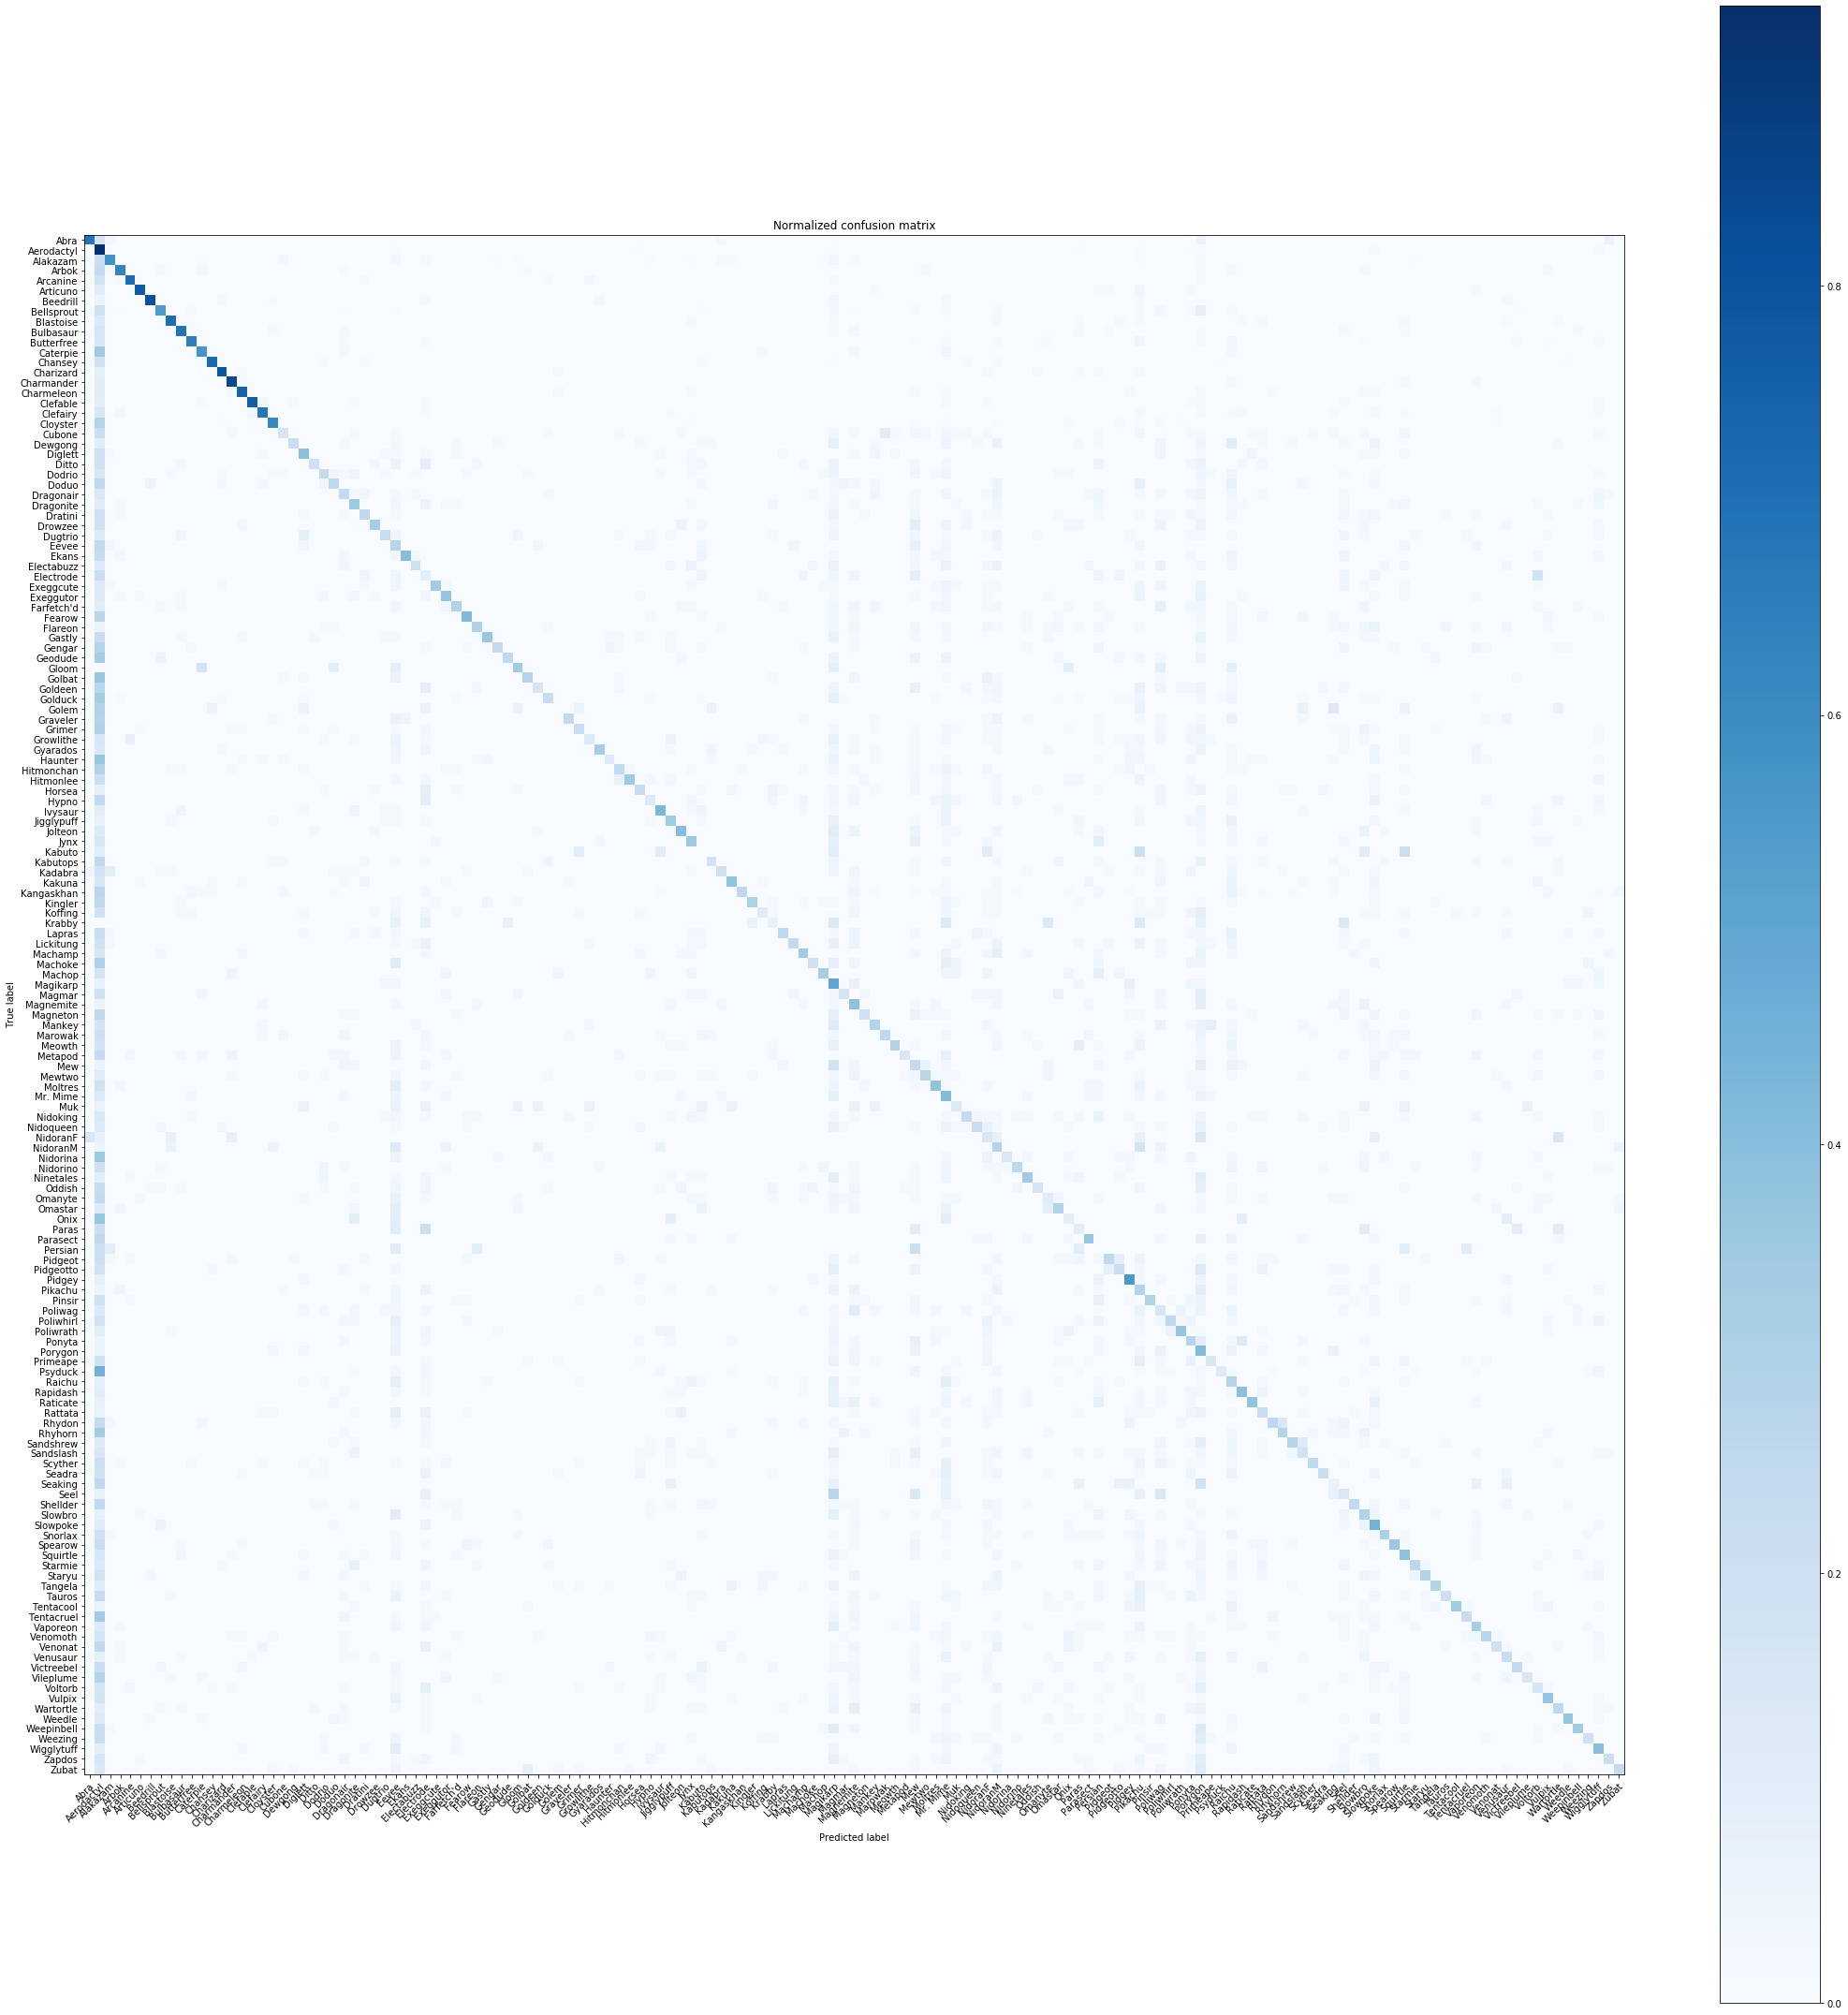

In [149]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        title = 'Normalized confusion matrix'
    else:
        title = 'Confusion matrix, without normalization'

    # Only use the labels that appear in the data
    classes = list(classes.values())
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots(figsize=(30,30))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    thresh = cm.max() / 2.
    fig.tight_layout()
    return ax


cm = confusion_matrix(hog_y_test,pred[1].flatten())
cm_norm = cm.astype('float')/ cm.sum(axis=1)
df_cm = pd.DataFrame(data=cm, index=labels_dict.values(), columns=labels_dict.values())

plot_confusion_matrix(cm,labels_dict, normalize=True)

In [150]:
report = classification_report(hog_y_test,pred[1].flatten(),target_names=list(labels_dict.values()),output_dict = True)
classification_report_df = pd.DataFrame(report).T
classification_report_df = classification_report_df[0:151]

In [151]:
classification_report_df.describe()

,f1-score,precision,recall,support
count,151.000000,151.000000,151.000000,151.000000
mean,0.355109,0.522958,0.310949,55.662252
std,0.198103,0.276910,0.181320,29.817643
min,0.000000,0.000000,0.000000,10.000000
25%,0.231327,0.299601,0.203893,40.500000
50%,0.333333,0.575000,0.272727,51.000000
75%,0.425833,0.736232,0.368993,59.000000
max,0.876106,0.954023,0.930380,159.000000


In [152]:
misclassified = y_test[np.where(y_test != pred[1].flatten())]


# Deep Learning (CNN)
## Data Augmentation

In [163]:
X_train.shape

(33617, 64, 64, 3)

    Data Augmemntation changes an input image in variety ways such as flipping horizontally/vertically or changing brightness of image, so that I can prevent overffiting from a model.
    Furthermore, the goal when applying data augmentation is to increase the generalizability of the model

In [147]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)

In [195]:
data_aug = image.ImageDataGenerator(
    featurewise_center=False, # set input mean to 0 over the dataset
    featurewise_std_normalization=False, # divide input by std
    rotation_range=20, # randomly rotate images in the range 
    zoom_range=0.2,
    width_shift_range=0.2, # randomly shift images in x-axis
    height_shift_range=0.2, # randomly shift images in y-axis
    horizontal_flip=True,
    fill_mode='nearest'
    )

# compute quantities required for featurewise normalization
# (std, mean, and principal components if ZCA whitening is applied)
data_aug.fit(X_train)

# Examples of Data Augmentation

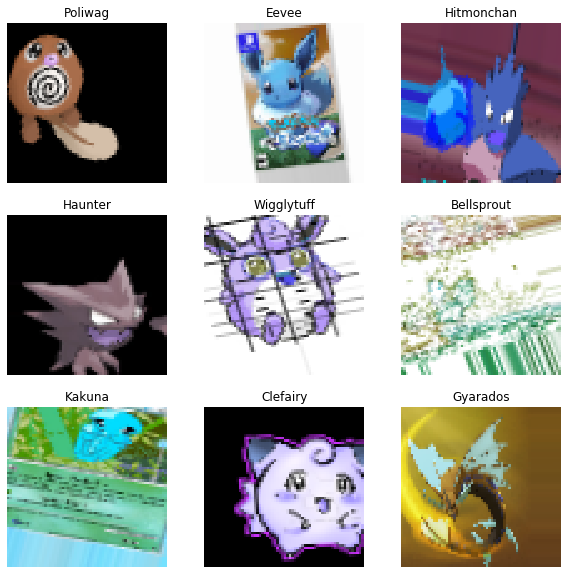

In [196]:
for X_batch, y_batch in data_aug.flow(X_train, y_train, batch_size=9):
    # create a grid of 3x3 images
    plt.figure(figsize=(10,10))
    for i in range(0, 9):
        plt.subplot(330 + 1 + i)
        plt.title(labels_dict[y_batch[i]])
        plt.imshow(X_batch[i].reshape(64, 64, 3))
        plt.axis('off')
    # show the plot
    plt.show()
    break

## Converting a class vector (integers) to a binary class matrix

In [ ]:
num_classes = 151
y_train = np_utils.to_categorical(y_train, num_classes, dtype='float32')
y_test = np_utils.to_categorical(y_test, num_classes, dtype='float32')

In [199]:
cnn_model = Sequential()
cnn_model.add(Convolution2D(32, 3, 3, input_shape = (64, 64, 3), activation='relu'))
cnn_model.add(Convolution2D(32, 3, 3, activation='relu')